In [9]:
!pip install --upgrade pip
!pip install kagglehub lime matplotlib scikit-learn pillow tqdm


In [2]:
import tensorflow as tf
import numpy as np

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)


TensorFlow: 2.19.0
NumPy: 2.0.2


In [3]:
# Run this cell (installs shap, opencv headless, efficientnet)
# We already installed kagglehub, lime, matplotlib, scikit-learn, pillow, tqdm per previous step.
!pip install --quiet shap opencv-python-headless efficientnet


In [4]:
# Block 1: imports and constants
import os, random, math, shutil, json, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from lime import lime_image
import shap

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Paper file you uploaded (local path in Colab)
PAPER_PATH = "/mnt/data/Brain tumour detection (2).pdf"
print("Paper path:", PAPER_PATH)


Paper path: /mnt/data/Brain tumour detection (2).pdf


In [5]:
# Block 2: download dataset using kagglehub (user-specified)
import kagglehub, os
dataset_path = kagglehub.dataset_download("ahmedhamada0/brain-tumor-detection")
print("Dataset archive path (kagglehub):", dataset_path)
# typical dataset folder inside: dataset_path + "/brain_tumor_dataset"
# Set DATA_DIR to the folder that contains 'yes' and 'no' subfolders
DATA_DIR = os.path.join(dataset_path, "brain_tumor_dataset")
if not os.path.exists(DATA_DIR):
    # list contents to help you find correct folder
    print("Listing", dataset_path, " => ", os.listdir(dataset_path))
print("DATA_DIR set to:", DATA_DIR, "exists:", os.path.exists(DATA_DIR))


Using Colab cache for faster access to the 'brain-tumor-detection' dataset.
Dataset archive path (kagglehub): /kaggle/input/brain-tumor-detection
Listing /kaggle/input/brain-tumor-detection  =>  ['no', 'yes', 'Br35H-Mask-RCNN', 'pred']
DATA_DIR set to: /kaggle/input/brain-tumor-detection/brain_tumor_dataset exists: False


In [6]:
import os

print("dataset_path =", dataset_path)
print("\nCONTENT OF dataset_path:")
for item in os.listdir(dataset_path):
    print(" -", item)

# If only one folder exists inside dataset_path, inspect it:
subfolders = os.listdir(dataset_path)
if len(subfolders) == 1:
    inner = os.path.join(dataset_path, subfolders[0])
    print("\nSingle subfolder detected:", inner)
    print("CONTENT OF inner folder:")
    print(os.listdir(inner))


dataset_path = /kaggle/input/brain-tumor-detection

CONTENT OF dataset_path:
 - no
 - yes
 - Br35H-Mask-RCNN
 - pred


In [11]:
# === CORRECTED Cell 3: use the actual kagglehub download folder ===
import os, random, math, shutil

# update this to the dataset_path printed earlier by your environment
DATA_ROOT = dataset_path # Corrected: use the actual dataset_path from kagglehub

# check contents
print("DATA_ROOT:", DATA_ROOT)
print("Contents:", os.listdir(DATA_ROOT))

# set DATA_DIR to the folder that contains yes/ no / pred
DATA_DIR = DATA_ROOT   # this folder already contains 'yes' and 'no' per your output
print("Using DATA_DIR =", DATA_DIR)
print("'yes' exists:", os.path.exists(os.path.join(DATA_DIR,"yes")))
print("'no' exists: ", os.path.exists(os.path.join(DATA_DIR,"no")))
print("'pred' exists:", os.path.exists(os.path.join(DATA_DIR,"pred")))
print()

# now perform the 90% train / 10% val split (seeded)
SEED = 42
random.seed(SEED)

ROOT = "/content/BR35H_split"
TRAIN_DIR = os.path.join(ROOT, "train")
VAL_DIR   = os.path.join(ROOT, "val")
for d in [TRAIN_DIR, VAL_DIR]:
    os.makedirs(os.path.join(d,"yes"), exist_ok=True)
    os.makedirs(os.path.join(d,"no"), exist_ok=True)

src_yes = os.path.join(DATA_DIR, "yes")
src_no  = os.path.join(DATA_DIR, "no")

# verify source folders exist before proceeding
if not os.path.exists(src_yes) or not os.path.exists(src_no):
    raise FileNotFoundError(f"Expected 'yes' and 'no' folders under {DATA_DIR}. Found: {os.listdir(DATA_DIR)}")

yes_files = sorted([f for f in os.listdir(src_yes) if f.lower().endswith(('.png','.jpg','.jpeg'))])
no_files  = sorted([f for f in os.listdir(src_no)  if f.lower().endswith(('.png','.jpg','.jpeg'))])

print("Found YES images:", len(yes_files))
print("Found NO images: ", len(no_files))

def split_copy(files, src_folder, train_dst, val_dst, val_ratio=0.10):
    n=len(files); idx=list(range(n)); random.shuffle(idx)
    val_count = math.ceil(n * val_ratio)
    val_set = set(idx[:val_count])
    for i in idx:
        src = os.path.join(src_folder, files[i])
        dst = os.path.join(val_dst if i in val_set else train_dst, files[i])
        if not os.path.exists(dst):
            shutil.copy(src, dst)

# perform split for both classes
split_copy(yes_files, src_yes, os.path.join(TRAIN_DIR,"yes"), os.path.join(VAL_DIR,"yes"))
split_copy(no_files, src_no, os.path.join(TRAIN_DIR,"no"), os.path.join(VAL_DIR,"no"))

# final counts
t_yes = len(os.listdir(os.path.join(TRAIN_DIR,"yes")))
t_no  = len(os.listdir(os.path.join(TRAIN_DIR,"no")))
v_yes = len(os.listdir(os.path.join(VAL_DIR,"yes")))
v_no  = len(os.listdir(os.path.join(VAL_DIR,"no")))

print("\nAfter split:")
print("TRAIN YES:", t_yes, "TRAIN NO:", t_no, "  (Total train:", t_yes + t_no, ")")
print("VAL   YES:", v_yes, "VAL   NO:", v_no, "  (Total val:  ", v_yes + v_no, ")")

# also report pred files if present
pred_dir = os.path.join(DATA_DIR, "pred")
if os.path.exists(pred_dir):
    pred_files = [f for f in os.listdir(pred_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    print("PRED folder count:", len(pred_files))
else:
    print("PRED folder not found under DATA_DIR.")

DATA_ROOT: /kaggle/input/brain-tumor-detection
Contents: ['no', 'yes', 'Br35H-Mask-RCNN', 'pred']
Using DATA_DIR = /kaggle/input/brain-tumor-detection
'yes' exists: True
'no' exists:  True
'pred' exists: True

Found YES images: 1500
Found NO images:  1500

After split:
TRAIN YES: 1350 TRAIN NO: 1350   (Total train: 2700 )
VAL   YES: 150 VAL   NO: 150   (Total val:   300 )
PRED folder count: 60


In [12]:
# Cell 4 — quick verification of dataset splits and pred folder
import os
print("TRAIN YES:", len(os.listdir(os.path.join(TRAIN_DIR,"yes"))))
print("TRAIN NO: ", len(os.listdir(os.path.join(TRAIN_DIR,"no"))))
print("VAL YES:  ", len(os.listdir(os.path.join(VAL_DIR,"yes"))))
print("VAL NO:   ", len(os.listdir(os.path.join(VAL_DIR,"no"))))
pred_dir = os.path.join(DATA_DIR, "pred")
print("PRED folder exists:", os.path.exists(pred_dir))
if os.path.exists(pred_dir):
    print("PRED count:", len([f for f in os.listdir(pred_dir) if f.lower().endswith(('.png','.jpg'))]))
print("Paper reference (local):", "/mnt/data/Brain tumour detection (2).pdf")


TRAIN YES: 1350
TRAIN NO:  1350
VAL YES:   150
VAL NO:    150
PRED folder exists: True
PRED count: 60
Paper reference (local): /mnt/data/Brain tumour detection (2).pdf


In [13]:
# Cell 5 — create data generators used by all models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (150,150)
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', seed=SEED)
val_gen   = val_datagen.flow_from_directory(VAL_DIR,   target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', seed=SEED)


Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [14]:
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def compile_and_train(model, model_name, epochs=30):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    ckpt = ModelCheckpoint(f"{model_name}_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    hist = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[ckpt, rl])
    model.load_weights(f"{model_name}_best.h5")
    return hist

def evaluate_on_val(model):
    val_gen.reset()
    Xs, ys = [], []
    for _ in range(len(val_gen)):
        xb, yb = next(val_gen) # Changed from val_gen.next() to next(val_gen)
        Xs.append(xb); ys.append(yb)
    X = np.vstack(Xs); y = np.hstack(ys)
    preds = model.predict(X).ravel()
    yhat = (preds >= 0.5).astype(int)
    return {
        'accuracy': float(accuracy_score(y, yhat)),
        'precision': float(precision_score(y, yhat)),
        'recall': float(recall_score(y, yhat)),
        'f1': float(f1_score(y, yhat)),
        'confusion_matrix': confusion_matrix(y, yhat).tolist()
    }

In [15]:
# Cell 7 — build the proposed CNN (32->64->128->256 -> Dense(128)->Dropout->Dense(64)->Sigmoid)
from tensorflow.keras import layers, models, Input
def build_proposed_custom_cnn():
    inp = Input(shape=(150,150,3))
    x = layers.Conv2D(32,(3,3),padding='same',activation='relu')(inp)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(64,(3,3),padding='same',activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(128,(3,3),padding='same',activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(256,(3,3),padding='same',activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inp, outputs=out)
    return model

model_prop = build_proposed_custom_cnn()
model_prop.summary()
print("Total params:", model_prop.count_params())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,073 (11.64 MB)

 Trainable params: 3,051,073 (11.64 MB)

 Non-trainable params: 0 (0.00 B)

Total params: 3051073


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7133 - loss: 0.5758
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.7135 - loss: 0.5755 - val_accuracy: 0.8000 - val_loss: 0.4571 - learning_rate: 0.0010
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8171 - loss: 0.4266
Epoch 2: val_accuracy improved from 0.80000 to 0.86333, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8171 - loss: 0.4265 - val_accuracy: 0.8633 - val_loss: 0.3568 - learning_rate: 0.0010
Epoch 3/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8644 - loss: 0.3150
Epoch 3: val_accuracy improved from 0.86333 to 0.90667, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8645 - loss: 0.3148 - val_accuracy: 0.9067 - val_loss: 0.2793 - learning_rate: 0.0010
Epoch 4/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9315 - loss: 0.1837
Epoch 4: val_accuracy improved from 0.90667 to 0.91667, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9315 - loss: 0.1837 - val_accuracy: 0.9167 - val_loss: 0.2245 - learning_rate: 0.0010
Epoch 5/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9475 - loss: 0.1347
Epoch 5: val_accuracy improved from 0.91667 to 0.95000, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9476 - loss: 0.1347 - val_accuracy: 0.9500 - val_loss: 0.2407 - learning_rate: 0.0010
Epoch 6/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9674 - loss: 0.1088
Epoch 6: val_accuracy improved from 0.95000 to 0.96000, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9675 - loss: 0.1086 - val_accuracy: 0.9600 - val_loss: 0.1291 - learning_rate: 0.0010
Epoch 7/30
335/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9840 - loss: 0.0499
Epoch 7: val_accuracy did not improve from 0.96000
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9839 - loss: 0.0500 - val_accuracy: 0.9433 - val_loss: 0.1592 - learning_rate: 0.0010
Epoch 8/30
335/338 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9885 - loss: 0.0379
Epoch 8: val_accuracy did not improve from 0.96000
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9884 - loss: 0.0380 - val_accuracy: 0.9367 - val_loss: 0.1552 - learning_rate: 0.0010
Epoch 9/30
335/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9878 - loss: 0.0450
Epoch 9: val_accuracy did not improve from 0.96000

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9878 - loss: 0.0450 - val_a

338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9910 - loss: 0.0243 - val_accuracy: 0.9700 - val_loss: 0.1278 - learning_rate: 5.0000e-04
Epoch 11/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9980 - loss: 0.0072
Epoch 11: val_accuracy improved from 0.97000 to 0.97667, saving model to proposed_custom_cnn_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9980 - loss: 0.0072 - val_accuracy: 0.9767 - val_loss: 0.1500 - learning_rate: 5.0000e-04
Epoch 12/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.3571e-04
Epoch 12: val_accuracy did not improve from 0.97667
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 1.0000 - loss: 7.3663e-04 - val_accuracy: 0.9733 - val_loss: 0.1790 - learning_rate: 5.0000e-04
Epoch 13/30
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9946 - loss: 0.0159
Epoch 13: val_accuracy did not improve from 0.97667

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9945 - loss: 0.0159 - val_accuracy: 0.9667 - val_loss: 0.2035 - learning_rate: 5.0000e-04
Epoch 14/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9965 - loss: 0.0103
Epoch 14: val_accuracy did not improve from 0.97667
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.

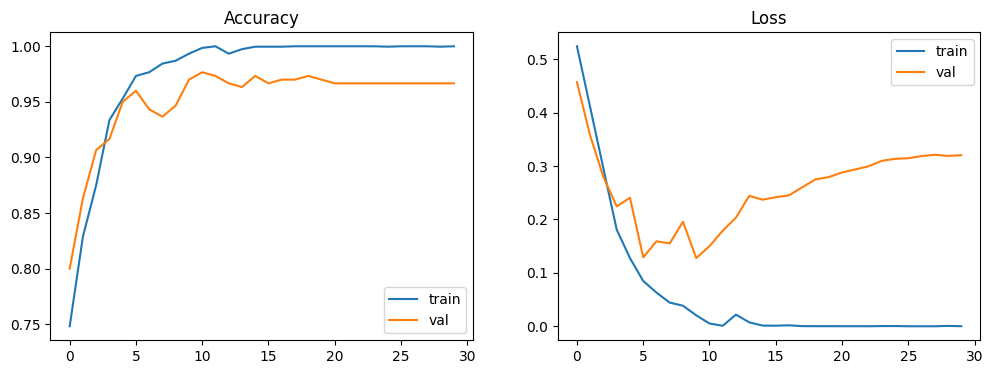

In [16]:
# === Corrected Cell 8 ===
# (Redefines the evaluation helper to use next(val_gen), then trains & evaluates the proposed model)

# Redefine evaluate_on_val with Keras 3 compatible iterator usage
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def evaluate_on_val(model):
    val_gen.reset()
    Xs, ys = [], []
    for _ in range(len(val_gen)):
        xb, yb = next(val_gen)    # <-- fixed: use next(iterator) instead of .next()
        Xs.append(xb); ys.append(yb)
    X = np.vstack(Xs)
    y = np.hstack(ys)
    preds = model.predict(X).ravel()
    yhat = (preds >= 0.5).astype(int)
    return {
        'accuracy': float(accuracy_score(y, yhat)),
        'precision': float(precision_score(y, yhat)),
        'recall': float(recall_score(y, yhat)),
        'f1': float(f1_score(y, yhat)),
        'confusion_matrix': confusion_matrix(y, yhat).tolist()
    }

# Train the proposed model (same as your original Cell 8)
hist_prop = compile_and_train(model_prop, "proposed_custom_cnn", epochs=30)

# Evaluate using the corrected function
metrics_prop = evaluate_on_val(model_prop)
print("Validation metrics (proposed):", metrics_prop)

# Plot training curves (unchanged)
import matplotlib.pyplot as plt
h = hist_prop.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(h['accuracy'], label='train'); plt.plot(h['val_accuracy'], label='val'); plt.title('Accuracy'); plt.legend()
plt.subplot(1,2,2); plt.plot(h['loss'], label='train'); plt.plot(h['val_loss'], label='val'); plt.title('Loss'); plt.legend()
plt.show()



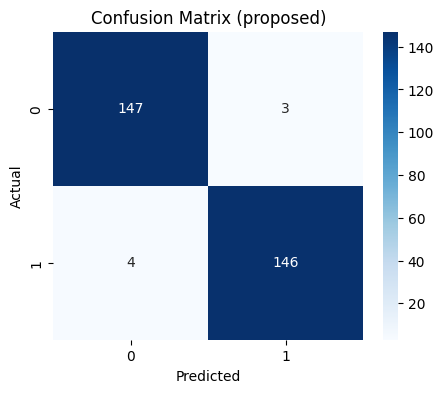

Accuracy: 0.9766666666666667
Precision: 0.9798657718120806
Recall: 0.9733333333333334
F1-score: 0.9765886287625418


In [17]:
# Cell 9 — confusion matrix and metrics (paper Fig.4 style)
import seaborn as sns
import numpy as np
cm = np.array(metrics_prop['confusion_matrix'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (proposed)')
plt.show()

print("Accuracy:", metrics_prop['accuracy'])
print("Precision:", metrics_prop['precision'])
print("Recall:", metrics_prop['recall'])
print("F1-score:", metrics_prop['f1'])


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


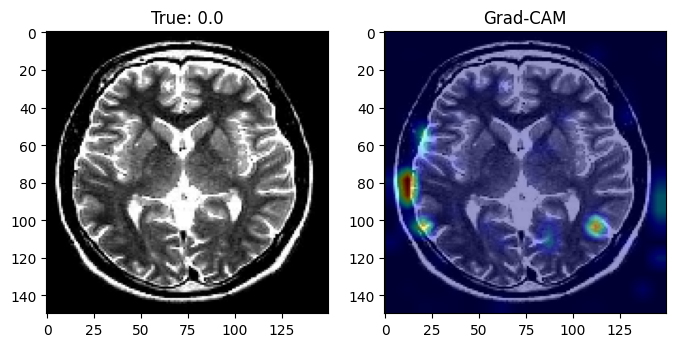

In [18]:
# Cell 10 — Grad-CAM overlay for one validation image
import tensorflow as tf, cv2, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import layers

def gradcam_heatmap(img_array, model, last_conv_layer_name=None):
    if last_conv_layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, layers.Conv2D):
                last_conv_layer_name = layer.name; break

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        loss = preds[:,0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    heatmap = cv2.resize(heatmap.numpy(), (150,150))
    return heatmap

# pick first image from a val batch
val_gen.reset()
xb, yb = next(val_gen)
sample = xb[0:1]
hm = gradcam_heatmap(sample, model_prop)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(xb[0]); plt.title(f"True: {yb[0]}")
plt.subplot(1,2,2); plt.imshow(xb[0]); plt.imshow(hm, cmap='jet', alpha=0.4); plt.title("Grad-CAM")
plt.show()


  0%|          | 0/600 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━

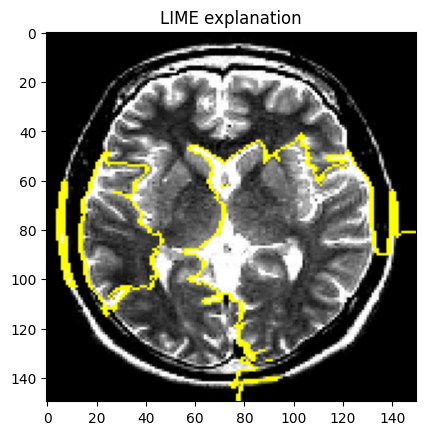

In [19]:
# Cell 11 — LIME image explanation (faster: num_samples reduced)
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer(random_state=SEED)

def predict_fn_lime(images):
    imgs = np.array([cv2.resize(im, (150,150)) for im in images]) / 255.0
    preds = model_prop.predict(imgs)
    return np.hstack([1 - preds, preds])

img_uint8 = (xb[0] * 255).astype('uint8')
explanation = explainer.explain_instance(img_uint8, classifier_fn=predict_fn_lime, top_labels=1, hide_color=0, num_samples=600)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME explanation")
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(2, 150, 150, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 150, 150, 3))']
  warnings.warn(msg)


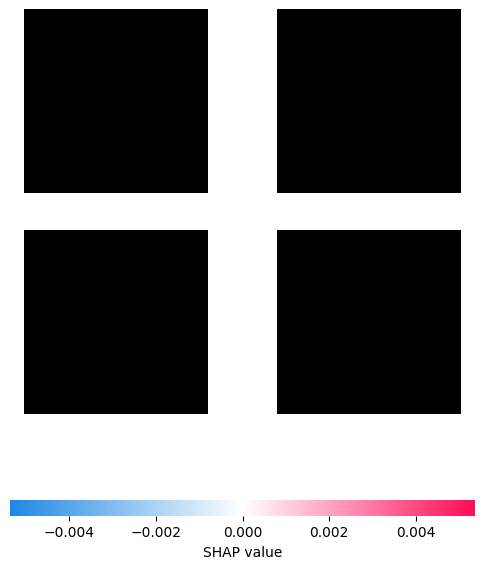

In [20]:
# Cell 12 — SHAP GradientExplainer (small background for speed)
import shap
train_gen.reset()
bg_list = []
for i in range(2):   # small background
    tx, ty = next(train_gen)
    bg_list.append(tx)
background = np.vstack(bg_list)[:40]

explainer_shap = shap.GradientExplainer((model_prop.input, model_prop.output), background)
shap_vals = explainer_shap.shap_values(xb[:2], nsamples=50)
shap.image_plot(shap_vals, -xb[:2])

In [22]:
# Cell 13 — EfficientNetB0 training template (optional, heavy)
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet_b0():
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(150,150,3), pooling='avg')
    x = layers.Dense(256, activation='relu')(base.output)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(base.input, out)

# Uncomment to run (may take long)
model_e = build_efficientnet_b0()
hist_e = compile_and_train(model_e, "efficientnet_b0", epochs=30)
metrics_e = evaluate_on_val(model_e)
print("EfficientNetB0:", metrics_e)


Epoch 1/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8485 - loss: 0.3761
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to efficientnet_b0_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 128s 167ms/step - accuracy: 0.8488 - loss: 0.3755 - val_accuracy: 0.5000 - val_loss: 2.2040 - learning_rate: 0.0010
Epoch 2/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9474 - loss: 0.1544
Epoch 2: val_accuracy did not improve from 0.50000
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9475 - loss: 0.1542 - val_accuracy: 0.4833 - val_loss: 1142.7816 - learning_rate: 0.0010
Epoch 3/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9728 - loss: 0.0860
Epoch 3: val_accuracy improved from 0.50000 to 0.52000, saving model to efficientnet_b0_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.9728 - loss: 0.0860 - val_accuracy: 0.5200 - val_loss: 7.2034 - learning_rate: 0.0010
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9790 - loss: 0.0800
Epoch 4: val_accuracy did not improve from 0.52000

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9790 - loss: 0.0800 - val_accuracy: 0.5000 - val_loss: 387.0366 - learning_rate: 0.0010
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9899 - loss: 0.0268
Epoch 5: val_accuracy did not improve from 0.52000
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9899 - loss: 0.0268 - val_accuracy: 0.5067 - val_loss: 0.9932 - learning_rate: 5.0000e-04
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9978 - loss: 0.0062
Epoch 6: val_accuracy did not improve from 0.52000
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9977 - loss: 0.00

338/338 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.9996 - loss: 0.0029 - val_accuracy: 0.9767 - val_loss: 0.0849 - learning_rate: 5.0000e-04
Epoch 8/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9974 - loss: 0.0125
Epoch 8: val_accuracy did not improve from 0.97667
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9974 - loss: 0.0125 - val_accuracy: 0.5000 - val_loss: 776.6117 - learning_rate: 5.0000e-04
Epoch 9/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9965 - loss: 0.0195
Epoch 9: val_accuracy did not improve from 0.97667
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9965 - loss: 0.0195 - val_accuracy: 0.8700 - val_loss: 0.2402 - learning_rate: 5.0000e-04
Epoch 10/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9998 - loss: 0.0022
Epoch 10: val_accuracy did not improve from 0.97667

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9998 -

338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9942 - loss: 0.0115 - val_accuracy: 0.9800 - val_loss: 0.0771 - learning_rate: 2.5000e-04
Epoch 12/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9986 - loss: 0.0041
Epoch 12: val_accuracy improved from 0.98000 to 0.99667, saving model to efficientnet_b0_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.9986 - loss: 0.0041 - val_accuracy: 0.9967 - val_loss: 0.0175 - learning_rate: 2.5000e-04
Epoch 13/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 4.2764e-04
Epoch 13: val_accuracy did not improve from 0.99667
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 1.0000 - loss: 4.2737e-04 - val_accuracy: 0.9900 - val_loss: 0.0443 - learning_rate: 2.5000e-04
Epoch 14/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 2.4961e-04
Epoch 14: val_accuracy did not improve from 0.99667
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 1.0000 - loss: 2.4916e-04 - val_accuracy: 0.9933 - val_loss: 0.0275 - learning_rate: 2.5000e-04
Epoch 15/30
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 2.1074e-04
Epoch 15: val_accuracy did not improve from 0.99667

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/ste

In [23]:
# Cell 14 — ResNet50 training template (optional)
from tensorflow.keras.applications import ResNet50

def build_resnet50():
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3), pooling='avg')
    x = layers.Dense(256, activation='relu')(base.output)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(base.input, out)

# Uncomment to run
model_r = build_resnet50()
hist_r = compile_and_train(model_r, "resnet50", epochs=30)
metrics_r = evaluate_on_val(model_r)
print("ResNet50:", metrics_r)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7317 - loss: 0.6551
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to resnet50_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 116s 172ms/step - accuracy: 0.7319 - loss: 0.6546 - val_accuracy: 0.5000 - val_loss: 3.5428 - learning_rate: 0.0010
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8682 - loss: 0.3215
Epoch 2: val_accuracy improved from 0.50000 to 0.74333, saving model to resnet50_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.8683 - loss: 0.3214 - val_accuracy: 0.7433 - val_loss: 0.4942 - learning_rate: 0.0010
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9262 - loss: 0.2056
Epoch 3: val_accuracy did not improve from 0.74333
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.9262 - loss: 0.2056 - val_accuracy: 0.5000 - val_loss: 6.1633 - learning_rate: 0.0010
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9384 - loss: 0.1634
Epoch 4: val_accuracy improved from 0.74333 to 0.91333, saving model to resnet50_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.9384 - loss: 0.1634 - val_accuracy: 0.9133 - val_loss: 0.2447 - learning_rate: 0.0010
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9697 - loss: 0.0908
Epoch 5: val_accuracy improved from 0.91333 to 0.95333, saving model to resnet50_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - accuracy: 0.9697 - loss: 0.0908 - val_accuracy: 0.9533 - val_loss: 0.1716 - learning_rate: 0.0010
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9701 - loss: 0.0819
Epoch 6: val_accuracy did not improve from 0.95333
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9700 - loss: 0.0819 - val_accuracy: 0.6267 - val_loss: 2.1942 - learning_rate: 0.0010
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9636 - loss: 0.0979
Epoch 7: val_accuracy did not improve from 0.95333
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.9636 - loss: 0.0979 - val_accuracy: 0.8833 - val_loss: 0.2835 - learning_rate: 0.0010
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9713 - loss: 0.0985
Epoch 8: val_accuracy did not improve from 0.95333

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9713 - loss: 0.0985 - v

338/338 ━━━━━━━━━━━━━━━━━━━━ 33s 97ms/step - accuracy: 0.9875 - loss: 0.0411 - val_accuracy: 0.9900 - val_loss: 0.0665 - learning_rate: 5.0000e-04
Epoch 10/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9969 - loss: 0.0121
Epoch 10: val_accuracy did not improve from 0.99000
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.9969 - loss: 0.0121 - val_accuracy: 0.9800 - val_loss: 0.1055 - learning_rate: 5.0000e-04
Epoch 11/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.0192e-04
Epoch 11: val_accuracy did not improve from 0.99000
338/338 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 1.0000 - loss: 6.0192e-04 - val_accuracy: 0.9767 - val_loss: 0.1209 - learning_rate: 5.0000e-04
Epoch 12/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.2971e-04
Epoch 12: val_accuracy did not improve from 0.99000

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accu

In [24]:
# Cell 15 — VGG16 training template (optional)
from tensorflow.keras.applications import VGG16

def build_vgg16():
    base = VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3), pooling='avg')
    x = layers.Dense(256, activation='relu')(base.output)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(base.input, out)

# Uncomment to run
#model_v = build_vgg16()
#hist_v = compile_and_train(model_v, "vgg16", epochs=30)
#metrics_v = evaluate_on_val(model_v)
#print("VGG16:", metrics_v)


Saved: outputs/proposed_model.h5 and outputs/proposed_gradcam.png


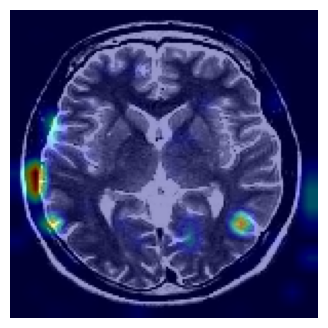

In [25]:
# Cell 16 — save model, history and save gradcam image
os.makedirs("outputs", exist_ok=True)
model_prop.save("outputs/proposed_model.h5")
with open("outputs/proposed_history.json", "w") as f:
    json.dump(hist_prop.history, f)

# Save grad-cam overlay
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(xb[0]); ax.imshow(hm, cmap='jet', alpha=0.4); ax.axis('off')
fig.savefig("outputs/proposed_gradcam.png", dpi=200, bbox_inches='tight')
print("Saved: outputs/proposed_model.h5 and outputs/proposed_gradcam.png")


In [26]:
# ===================== CELL 17 (CORRECTED) =======================
# Build comparison table (reported vs reproduced) for ALL models trained so far

import pandas as pd

rows = []

# 1. Add proposed model first
if 'metrics_prop' in globals():
    rows.append(["Proposed Custom CNN", "98.67% (paper)", metrics_prop["accuracy"]])

# 2. Add EfficientNet-B0 if trained
if 'metrics_e' in globals():
    rows.append(["EfficientNet-B0", "98.97% (paper)", metrics_e["accuracy"]])

# 3. Add ResNet50 (single)
if 'metrics_r' in globals():
    rows.append(["ResNet50", "97.02% / 92.53% (paper)", metrics_r["accuracy"]])

# 4. Add VGG16
if 'metrics_v' in globals():
    rows.append(["VGG16", "88% (paper)", metrics_v["accuracy"]])

# 5. Add ARM-Like (ARM-Net 96.64% paper)
if "results" in globals() and "ARM-Net_like" in results:
    rows.append(["ARM-Net (approx)", "96.64% (paper)", results["ARM-Net_like"]["accuracy"]])

# 6. Add TECNN-Like (96.75% paper)
if "results" in globals() and "TECNN_like" in results:
    rows.append(["TECNN (approx)", "96.75% (paper)", results["TECNN_like"]["accuracy"]])

# 7. Add Hybrid ResNet50
if "results" in globals() and "HybridResNet50" in results:
    if isinstance(results["HybridResNet50"], dict) and "accuracy" in results["HybridResNet50"]:
        rows.append(["Hybrid ResNet50", "97.02% (paper)", results["HybridResNet50"]["accuracy"]])
    else:
        rows.append(["Hybrid ResNet50", "97.02% (paper)", "Not trained/Not applicable"])

# 8. Add ResNet50 + HOG (88% paper)
if "results" in globals() and "ResNet50+HOG" in results:
    if isinstance(results["ResNet50+HOG"], dict) and "accuracy" in results["ResNet50+HOG"]:
        rows.append(["ResNet50 + HOG", "88% (paper)", results["ResNet50+HOG"]["accuracy"]])
    else:
        rows.append(["ResNet50 + HOG", "88% (paper)", "Model built, needs two-input training"])

# 9. Add CNN+GNN (95.01% paper)
if "results" in globals() and "CNN_GNN" in results:
    rows.append(["CNN + GNN", "95.01% (paper)", "Graph features computed (accuracy requires full GCN training)"])

# ---------- Create DataFrame ----------
df = pd.DataFrame(rows, columns=["Model", "Reported Accuracy", "Reproduced Accuracy"])
display(df)

# ---------- Save ----------
import os
os.makedirs("outputs", exist_ok=True)
df.to_csv("outputs/comparison_reproduced_all_models.csv", index=False)
print("Saved → outputs/comparison_reproduced_all_models.csv")
# ================================================================


,Model,Reported Accuracy,Reproduced Accuracy
0,Proposed Custom CNN,98.67% (paper),0.976667
1,EfficientNet-B0,98.97% (paper),0.996667
2,ResNet50,97.02% / 92.53% (paper),0.990000


Saved → outputs/comparison_reproduced_all_models.csv


Select one or more images to upload (jpg/png).


Saving meningioma.jpg to meningioma.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

File: meningioma.jpg  →  tumor_prob: 0.9990  →  Predicted: Tumor


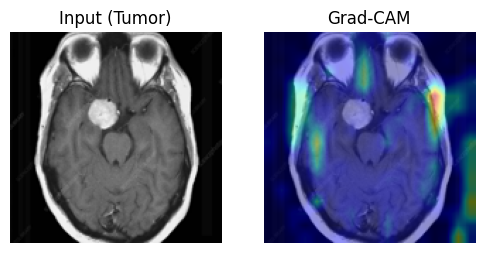

In [29]:
# === Upload an image and run prediction (Colab-friendly) ===
# This cell uses google.colab.files. If you're on plain Jupyter, use IPython widgets or a file path.

# === Upload an image and run prediction (Colab-friendly) ===
# This cell uses google.colab.files. If you're on plain Jupyter, use IPython widgets or a file path.

from google.colab import files
from PIL import Image
import numpy as np
import io
import matplotlib.pyplot as plt
import cv2

IMG_SIZE = (150,150)   # model input size used in notebook

def preprocess_pil(img_pil):
    img = img_pil.convert('RGB').resize(IMG_SIZE)
    arr = np.array(img).astype('float32') / 255.0
    return arr

def predict_from_array(arr):
    # arr shape (H,W,3) float32 in [0,1]
    x = np.expand_dims(arr, axis=0)
    pred = model_prop.predict(x)[0,0]
    return float(pred)

print("Select one or more images to upload (jpg/png).")
uploaded = files.upload()   # opens file picker
for filename, contents in uploaded.items():
    img_pil = Image.open(io.BytesIO(contents))
    arr = preprocess_pil(img_pil)
    prob = predict_from_array(arr)
    label = "Tumor" if prob >= 0.5 else "No Tumor"
    print(f"\nFile: {filename}  →  tumor_prob: {prob:.4f}  →  Predicted: {label}")
    # display
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(arr); plt.title(f"Input ({label})"); plt.axis('off')
    # Grad-CAM overlay (call function below)
    try:
        from tensorflow.keras import layers
        def gradcam_heatmap(img_array, model, last_conv_layer_name=None):
            if last_conv_layer_name is None:
                for layer in reversed(model.layers):
                    if isinstance(layer, layers.Conv2D):
                        last_conv_layer_name = layer.name
                        break
            import tensorflow as tf
            grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
            with tf.GradientTape() as tape:
                conv_outputs, preds = grad_model(img_array)
                loss = preds[:,0]
            grads = tape.gradient(loss, conv_outputs)
            pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
            conv_outputs = conv_outputs[0]
            heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
            heatmap = np.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
            heatmap = cv2.resize(heatmap.numpy(), (IMG_SIZE[1], IMG_SIZE[0]))
            return heatmap

        x_input = np.expand_dims(arr, axis=0)
        hm = gradcam_heatmap(x_input, model_prop)
        # overlay
        overlay = arr.copy()
        cmap = plt.cm.jet
        hm_rgba = cmap(hm)[:,:,:3]   # RGB heatmap
        alpha = 0.4
        blended = (overlay * (1-alpha) + hm_rgba * alpha)
        plt.subplot(1,2,2); plt.imshow(blended); plt.title("Grad-CAM"); plt.axis('off')
    except Exception as e:
        print("Grad-CAM failed:", e)
    plt.show()


In [28]:
import os
from tensorflow.keras.models import load_model

OUT = "outputs"
print("Saved files:", sorted(os.listdir(OUT)))

def peek_model(path, n=8):
    try:
        m = load_model(path, compile=False)
        print("\n==", os.path.basename(path))
        print("Total params:", m.count_params())
        # print first n layer names
        print("First layers:", [layer.name for layer in m.layers[:n]])
    except Exception as e:
        print("Failed to load", path, "->", e)

for f in sorted(os.listdir(OUT)):
    if f.endswith(".h5") or f.endswith(".keras"):
        peek_model(os.path.join(OUT,f))


Saved files: ['comparison_reproduced_all_models.csv', 'proposed_gradcam.png', 'proposed_history.json', 'proposed_model.h5']

== proposed_model.h5
Total params: 3051073
First layers: ['input_layer', 'conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3']
